In [ ]:
import matplotlib.pyplot as plt
#from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
#from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time
from tensorflow.keras.datasets import fashion_mnist
from keras.preprocessing.image import img_to_array, array_to_img
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

# Load Fashion MNIST Data

In [ ]:
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()


4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
trainX.shape

(60000, 28, 28)

# Reshape as per the tensor format required by tensorflow

In [ ]:
X=trainX.reshape(60000,28*28)
tX=testX.reshape(10000,28*28)

In [ ]:
classes = np.unique(trainY)
num_classes = len(classes)
num_classes

10

In [ ]:
train_X=np.dstack([X] * 3)
test_X=np.dstack([tX]*3)
train_X.shape,test_X.shape

((60000, 784, 3), (10000, 784, 3))

In [ ]:
# Reshape images as per the tensor format required by tensorflow
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

# Resize the images 48*48 as required by VGG16

In [ ]:

train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

# Pre-Process Data

In [ ]:
# Normalise the data and change data type
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [ ]:
# Converting Labels to one hot encoded format
train_Y_one_hot = to_categorical(trainY)
test_Y_one_hot = to_categorical(testY)

# Splitting Data

In [ ]:
# Splitting train data as train and validation data
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [ ]:
# Finally check the data size whether it is as per tensorflow and VGG16 requirement
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [ ]:
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (test_X)

# Define Parameters for VGG16 model

In [ ]:
# Define the parameters for instanitaing VGG16 model. 
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

- **weights** : specifies the weight checkpoint from which to initialize the model.

- **include_top** : refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because I intend to use my own densely connected classifier (with only 10 classes), I don’t need to include it.

- **input_shape** : optional shape tuple, only to be specified if include_top is False.

# Create VGG16 Base Model

In [ ]:
#  Create base model of VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
______________________________________________________________

# Feature Extraction From Base Model 

In [ ]:
# Extracting features
train_features = conv_base.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=BATCH_SIZE, verbose=1)

750/750 [==============================] - 5s 7ms/step


# Saving the features so that they can be used for future


In [ ]:
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, testY)
np.savez("val_features", val_features, valid_label)

In [ ]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [ ]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

# Define Top Layers

In [ ]:
# Define the densely connected classifier followed by leakyrelu layer and finally dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

# Model Compilation 

In [ ]:
# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['acc'])

# Define Callbacks

In [ ]:
#Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callback = [reduce_learning, eary_stopping]

# Train Model

In [ ]:
# Train the the model
history = model.fit(
    train_features_flat,
    train_label,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_label),
    callbacks=callback
)

Epoch 1/100
1500/1500 [==============================] - 4s 2ms/step - loss: 1.4603 - acc: 0.4605 - val_loss: 1.2201 - val_acc: 0.5320
Epoch 2/100
1500/1500 [==============================] - 4s 2ms/step - loss: 1.0793 - acc: 0.6055 - val_loss: 1.0023 - val_acc: 0.6453
Epoch 3/100
1500/1500 [==============================] - 4s 2ms/step - loss: 0.9791 - acc: 0.6415 - val_loss: 0.9108 - val_acc: 0.6668
Epoch 4/100
1500/1500 [==============================] - 4s 2ms/step - loss: 0.9267 - acc: 0.6606 - val_loss: 0.8719 - val_acc: 0.6856
Epoch 5/100
1500/1500 [==============================] - 4s 2ms/step - loss: 0.9019 - acc: 0.6697 - val_loss: 0.8920 - val_acc: 0.6790
Epoch 6/100
1477/1500 [============================>.] - ETA: 0s - loss: 0.8753 - acc: 0.6802
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1500/1500 [==============================] - 4s 2ms/step - loss: 0.8755 - acc: 0.6799 - val_loss: 0.8901 - val_acc: 0.6668
Epoch 7/100
1500/1500 [====

# Diagnostic Plots

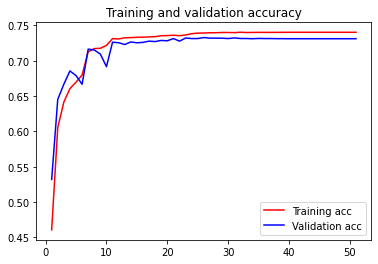

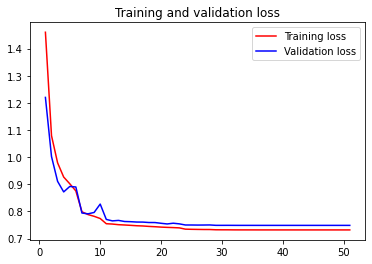

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()